In [1]:
%pylab inline
import cv2
import imutils
from imutils import contours
import matplotlib.patches as patches
import pytesseract
import zbar
import labelreader
import skimage.morphology

Populating the interactive namespace from numpy and matplotlib


In [60]:
image = cv2.imread("haar_classifier/new_supermarket_photos/spar_results/ok/7.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#grad = labelreader.imageGrads(gray)
grad = labelreader.imageGrads(labelreader.normalizeImage(gray))
borders, borderCnts = labelreader.imageBorders(grad)
objgrad = labelreader.imageObjgrad(labelreader.imageGrads(labelreader.normalizeImage(gray, borders)), borders)
#objgrad = labelreader.imageObjgrad(grad, borders)
cnts = labelreader.imageContours(objgrad)
boxes = labelreader.imageBoxes(objgrad)
lines = labelreader.imageLines(boxes)
lineboxes = labelreader.lineBoxes(lines, boxes)
linetexts = labelreader.imageTexts(gray, lineboxes, vmargin=2, hmargin=2)
print [(txt, b)
        for txt, b in zip(linetexts, lineboxes)
        if txt]

[(u'H1', (94, 171, 14, 13)), (u'WW', (111, 123, 56, 38)), (u'lln', (125, 124, 14, 59)), (u'H m', (138, 162, 53, 25)), (u'ms\u2018', (208, 188, 16, 14)), (u'W', (313, 70, 41, 140))]


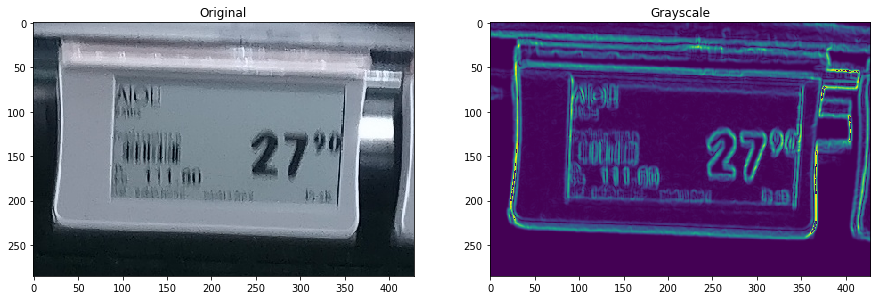

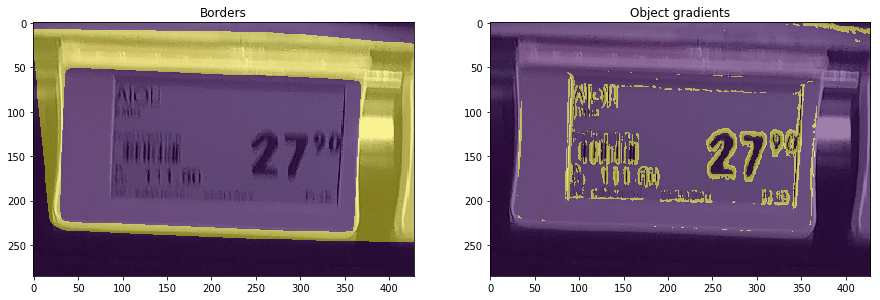

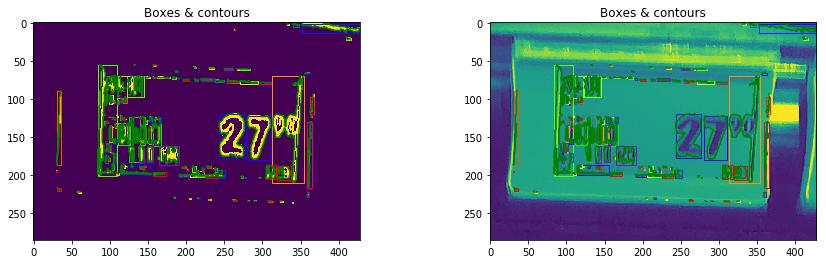

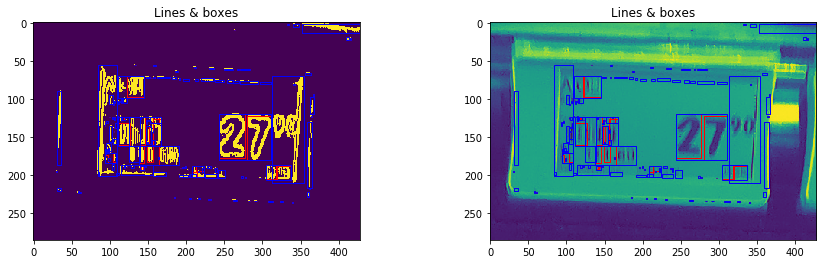

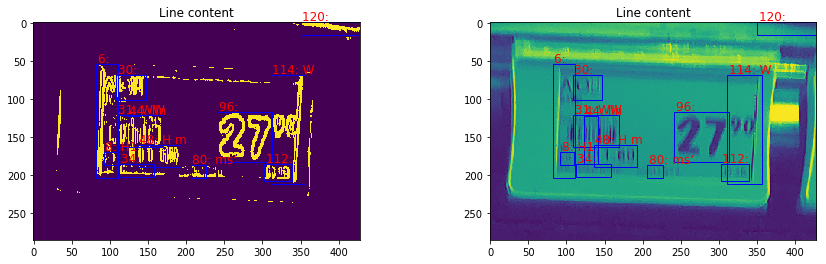

In [14]:
fig = plt.figure(); fig, axs = plt.subplots(1,2, figsize=(15,5)); axs = axs.flatten()
axs[0].imshow(image); axs[0].set_title('Original')
axs[1].imshow(gray); axs[1].set_title('Grayscale')
fig.show()

plt.imshow(grad)
plt.show()

fig = plt.figure(); fig, axs = plt.subplots(1,2, figsize=(15,5)); axs = axs.flatten()
axs[0].imshow(image, alpha=1); axs[0].imshow(borders, alpha=0.5); axs[0].set_title('Borders')
axs[1].imshow(image, alpha=1); axs[1].imshow(objgrad, alpha=0.5); axs[1].set_title('Object gradients')
fig.show()

fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrad); axs[0].set_title('Boxes & contours')
axs[1].imshow(gray); axs[1].set_title('Boxes & contours')
for idx in (0, 1):
    labelreader.drawCountours(axs[idx], cnts)
    labelreader.drawLines(axs[idx], lines, boxes)
fig.show()


fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrad); axs[0].set_title('Lines & boxes')
axs[1].imshow(gray); axs[1].set_title('Lines & boxes')
for idx in (0, 1):
    labelreader.drawLineParts(axs[idx], lines, boxes)
    labelreader.drawLineBoxes(axs[idx], lineboxes)
    fig.show()
    
        
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrad); axs[0].set_title('Line content')
axs[1].imshow(gray); axs[1].set_title('Line content')
for idx in (0, 1):
    labelreader.drawLineBoxesAndText(axs[idx], lineboxes, linetexts, vmargin=2, hmargin=2)
    fig.show()

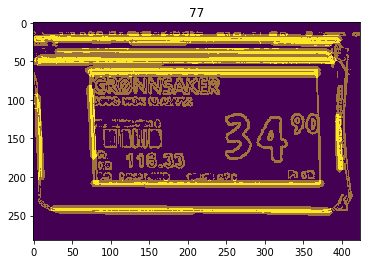

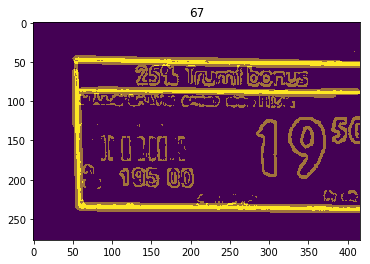

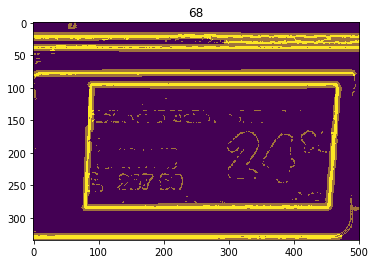

In [78]:
for name in (77, 67, 68):
    image = cv2.imread("haar_classifier/new_supermarket_photos/spar_results/ok/%s.jpg" % name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grad = labelreader.imageGrads(labelreader.normalizeImage(gray))

    size = int(min(*gray.shape) * 0.2)
    
    edges = cv2.threshold(grad, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=size,
        minLineLength=size,
        maxLineGap=0)

    borders = np.zeros(gray.shape)

    
    cmap = plt.get_cmap("winter")
    plt.title(str(name))
    plt.imshow(edges)
    for idx, line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            cv2.line(borders, (x1, y1), (x2, y2), 255, 8)
            #plt.plot([x1, x2], [y1, y2], '-', color=cmap(float(idx) / len(lines)), linewidth=8.0)
    plt.imshow(borders, alpha=0.5)
    plt.show()

In [63]:
min(*image.shape) * 0.2

0.6000000000000001

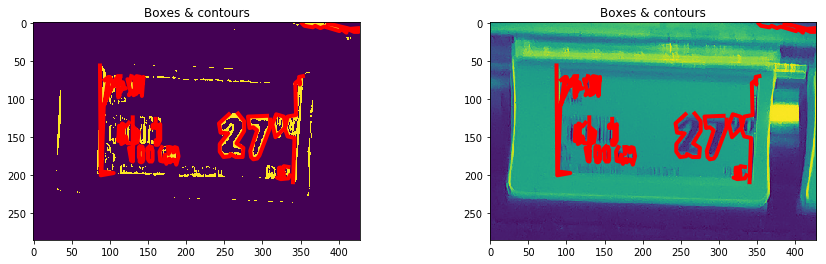

In [42]:
image = cv2.imread("haar_classifier/new_supermarket_photos/spar_results/ok/7.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grad = cv2.threshold(grad, 40, 255, cv2.THRESH_BINARY)[1]
borders, borderCnts = labelreader.imageBorders(grad)
objgrad = labelreader.imageObjgrad(labelreader.imageGrads(labelreader.normalizeImage(gray, borders)), borders)
cnts = labelreader.imageContours(objgrad)

cnts = [cnt for cnt in cnts if 
        cv2.contourArea(cnt) > 100]

cnts = [cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
        for cnt in cnts]

def drawCountours(ax, cnts, **kw):
    for c in cnts:
        ax.plot(c[:,0,0], c[:,0,1], **kw)
        
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(objgrad); axs[0].set_title('Boxes & contours')
axs[1].imshow(gray); axs[1].set_title('Boxes & contours')
for idx in (0, 1):
    drawCountours(axs[idx], cnts, color="red", linewidth=4.0)
fig.show()


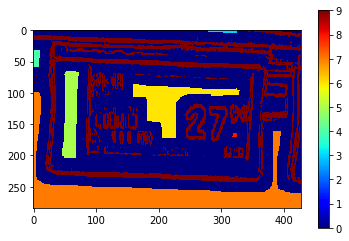

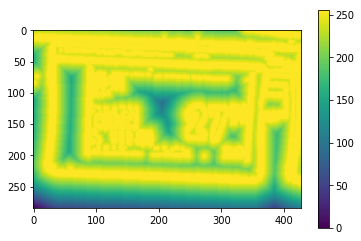

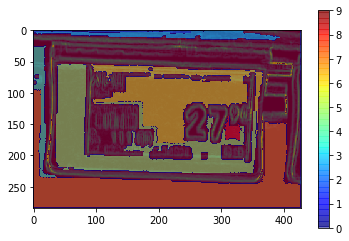

In [49]:
image = cv2.imread("haar_classifier/new_supermarket_photos/spar_results/ok/7.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
grad = labelreader.imageGrads(labelreader.normalizeImage(gray))
markers = grad
markers = cv2.threshold(markers, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
sure_bg = markers.copy()

markers = cv2.dilate(markers, cv2.getStructuringElement(cv2.MORPH_RECT, (31,31)))

markers = 255 - markers

ret, markerlabels = cv2.connectedComponents(markers)
# markerlabels = markerlabels+1

dist = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
dist = 255-cv2.dilate(dist, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)))
dist = cv2.distanceTransform(dist,cv2.DIST_L2,3)

dist = (dist / dist.max()) * 255
dist = 255 - dist
dist_ = dist
dist = cv2.cvtColor(dist.astype("uint8"),cv2.COLOR_GRAY2BGR)

markerlabels[sure_bg == 255] = markerlabels.max() + 1

out = markerlabels.copy()

out = cv2.watershed(dist,out)
out[out == -1] = 0

plt.imshow(markerlabels, cmap="jet"); plt.colorbar(); plt.show()
plt.imshow(dist_); plt.colorbar(); plt.show()
plt.imshow(grad); plt.imshow(out, alpha=0.5, cmap="jet"); plt.colorbar(); plt.show()

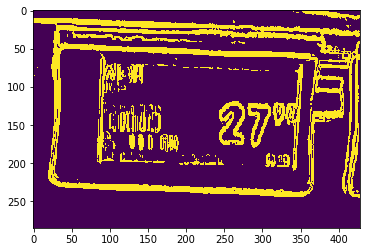

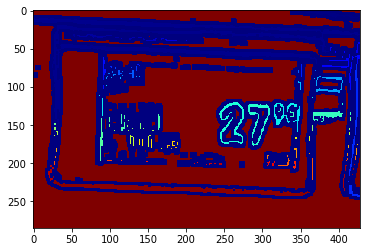

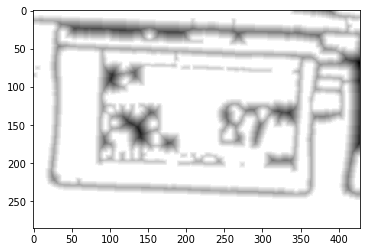

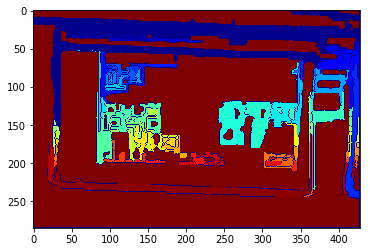

In [55]:
image = cv2.imread("haar_classifier/new_supermarket_photos/spar_results/ok/7.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
grad = labelreader.imageGrads(labelreader.normalizeImage(gray))
grad = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

sure_bg = cv2.dilate(grad, cv2.getStructuringElement(cv2.MORPH_RECT, (7,7)))

dist = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
dist = (dist / dist.max()) * 255
dist = cv2.cvtColor(dist.astype("uint8"),cv2.COLOR_GRAY2BGR)

markers = cv2.erode(grad, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)))

ret, markerlabels = cv2.connectedComponents(markers)
markerlabels[sure_bg == 0] = markerlabels.max() + 1 # -1

dist = 255 - dist
out = markerlabels.copy()
out = cv2.watershed(dist,out)
out[out == -1] = 0

plt.imshow(grad); plt.show()
plt.imshow(markerlabels, cmap="jet"); plt.show()
plt.imshow(dist); plt.show()
plt.imshow(out, cmap="jet"); plt.show()


In [13]:
out.dtype

dtype('int32')

In [42]:
dist.shape

(285, 428, 3)

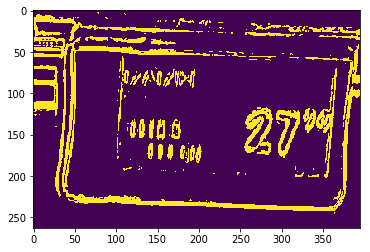

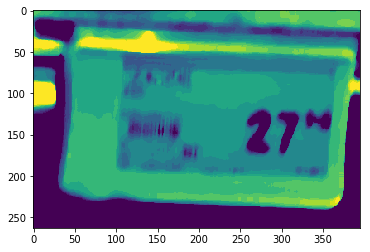

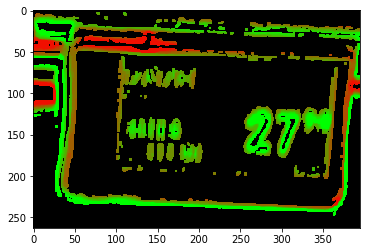

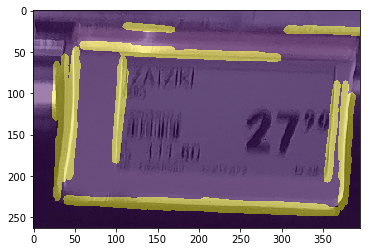

In [2]:
image = cv2.imread("haar_classifier/new_supermarket_photos/spar_results/ok/10.jpg")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

grad = labelreader.imageGrads(gray)
grad = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

plt.imshow(grad); plt.show()

grad = cv2.dilate(grad, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)))

cat = cv2.medianBlur(gray,11)
cat = labelreader.normalizeImage(cat)

cat = (cat / 16) * 16

plt.imshow(cat); plt.show()

o = np.zeros(gray.shape + (3,), dtype="uint8")
o[:,:,0] = (grad / 255.) * (cat)
o[:,:,1] = (grad / 255.) * (255 - cat)
o[:,:,2] = 0

plt.imshow(o); plt.show()

if 1:
    res = []
    for c in xrange(0, 16):
        layer = grad * (cat / 16 == c)
        #if layer.sum() > 200 * 255:
        layer = cv2.dilate(layer, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)))
        layer, cnt = labelreader.imageBordersHough(layer)
        res.append(layer)
    for layer in res[1:]:
        res[0] = res[0] | layer

    plt.imshow(image)
    plt.imshow(res[0], alpha=0.5); plt.show()


In [208]:
grad.dtype

dtype('uint8')

(18295,)